## Step 1: Import the necessary libraries:


In [18]:
import numpy as np
import pandas as pd
import networkx as nx
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import itertools
import ast
import matplotlib.pyplot as plt 
import os
import seaborn as sns

## Step 2: Define the environment:


In [19]:
devices_path = "./resources/devices.csv"
# tasks_path = "./resources/mini_tasks.csv"
tasks_path = "./resources/5050_tasks.csv"
dataFile = "./results/power.csv"

#### ALL THE DEVICES


In [20]:
devices = pd.read_csv(devices_path)

devices["voltages_frequencies"] = devices["voltages_frequencies"].apply(lambda x: ast.literal_eval(x))
devices["capacitance"] = devices["capacitance"].apply(
    lambda x: ast.literal_eval(x)
)
devices["occupied_cores"] = devices["occupied_cores"].apply(
    lambda x: ast.literal_eval(x)
)
devices["powerIdle"] = devices["powerIdle"].apply(
    lambda x: ast.literal_eval(x)
)
devices["acceptableTasks"] = devices["acceptableTasks"].apply(
    lambda x: ast.literal_eval(x)
)
devices = devices.drop(["Unnamed: 0"],axis=1)

### Step 2.2: Application


#### _ALL THE TASKS_


In [21]:
def regularize_any(any, mode):
    match mode:
        case 1: #time
            lower_bound =  0.00625
            upper_bound = 1
        case 2: #energy
            lower_bound = 0.0000405
            upper_bound = 1.2
        case 3: #power
            lower_bound = 0.00648
            upper_bound = 24.28 + 3.65 + 4.38412
        case 4: #cl
            lower_bound = 1e6
            upper_bound = 1e7

    # Clip the input to be within the specified bounds
    clipped_any = max(min(any, upper_bound), lower_bound)

    # Scale the energy within the bounds
    regularized_any = (clipped_any - lower_bound) / (upper_bound - lower_bound)
    regularized_any += 1e-5
    return regularized_any

In [22]:
def read_tasks():
    tasks = pd.read_csv(tasks_path)
    tasks = tasks.sample(frac=1)
    tasks = tasks.set_index("id")
    tasks_copy = tasks.copy()
    tasks_copy = tasks_copy.drop(["job","dependency","mobility","status"],axis=1)
    taskList = tasks_copy.index.tolist()
    return taskList, tasks_copy

## Step 4 : DDT


### Step 4.1: Initializing The tree


In [23]:
class DDT(nn.Module):
    def __init__(self, num_input, num_output, depth, max_depth, num_epoch,counter=0, exploration_rate=0):
        super(DDT, self).__init__()
        self.depth = depth
        self.max_depth = max_depth
        self.epsilon = 1e-5
        self.num_epoch = num_epoch
        self.exp_mid_bound = self.num_epoch * self.epsilon
        self.exploration_rate = self.exp_mid_bound + (self.exp_mid_bound / 2)
        self.exp_threshold = self.exp_mid_bound - (self.exp_mid_bound / 2)
        self.shouldExplore = 1
        self.counter = counter 
        if depth != max_depth:
            self.weights = nn.Parameter(torch.empty(num_input).normal_(mean=0, std=0.1))
            self.bias = nn.Parameter(torch.zeros(1))
            self.alpha = nn.Parameter(torch.zeros(1))
        if depth == max_depth:
            self.prob_dist = nn.Parameter(torch.zeros(num_output))
        if depth < max_depth:
            self.left = DDT(num_input, num_output, depth + 1, max_depth,self.num_epoch,self.counter, self.exploration_rate)
            self.right = DDT(num_input, num_output, depth + 1, max_depth,self.num_epoch,self.counter, self.exploration_rate)

    def forward(self, x, path=""):
        if self.depth == self.max_depth:
            return self.prob_dist, path
        val = torch.sigmoid(self.alpha * (torch.matmul(x, self.weights) + self.bias))
        a = np.random.random()
        a = float("{:.6f}".format(a))
        if a < self.exploration_rate and self.shouldExplore:
            self.counter +=1
            val = 1 - val
            self.exploration_rate -= self.epsilon
            if self.exploration_rate < self.exp_threshold:
                self.shouldExplore = 0
                
        if val >= 0.5:
            right_output, right_path = self.right(x, path + "R")
            return val * right_output, right_path
        else:
            left_output, left_path = self.left(x, path + "L")
            return (1 - val) * left_output, left_path

## Step 5: RL


In [24]:
def calc_execution_time(device, task, core, dvfs):
    if device['id'] == "cloud":
        return task["computationalLoad"] / device["voltages_frequencies"][0]
    else:
        return task["computationalLoad"] / device["voltages_frequencies"][core][dvfs][0]


def calc_power_consumption(device, task, core, dvfs):
    if device['id'] == "cloud":return 13.85 
    return (device["capacitance"][core]* (device["voltages_frequencies"][core][dvfs][1] ** 2)* device["voltages_frequencies"][core][dvfs][0])
def calc_energy(device, task, core, dvfs):
    return calc_execution_time(device, task, core, dvfs) * calc_power_consumption(device, task, core, dvfs)


def calc_total(device, task, core, dvfs):
    timeTransMec = 0
    timeTransCC = 0
    exeTime = 0

    transferRate5g =1e9
    latency5g=5e-3
    transferRateFiber =1e10
    latencyFiber=1e-3

    timeDownMec = task["returnDataSize"] / transferRate5g
    timeDownMec += latency5g
    timeUpMec = task["dataEntrySize"] / transferRate5g
    timeUpMec += latency5g

    alpha = 52e-5
    beta = 3.86412
    powerMec = alpha * 1e9 / 1e6 + beta

    timeDownCC = task["returnDataSize"] / transferRateFiber
    timeDownCC += latencyFiber
    timeUpCC = task["dataEntrySize"] / transferRateFiber
    timeUpCC += latencyFiber

    powerCC = 3.65 


    if device["id"].startswith("mec"):
        timeTransMec =  timeUpMec +  timeDownMec 
        exeTime = calc_execution_time(device, task, core, dvfs)
        totalTime = exeTime + timeTransMec
        p = calc_power_consumption(device, task, core, dvfs) 
        totalPower = p + powerMec
        

    elif device['id'].startswith("cloud"):
        timeTransMec =  timeUpMec +  timeDownMec 
        timeTransCC = timeUpCC+timeDownCC
        exeTime = calc_execution_time(device, task, core, dvfs)
        totalTime =  exeTime + timeTransMec +timeTransCC
        p = calc_power_consumption(device, task, core, dvfs)
        totalPower = p + powerCC + powerMec

        

    elif device['id'].startswith("iot"):
        exeTime = calc_execution_time(device, task, core, dvfs)
        totalTime = exeTime
        p = calc_power_consumption(device, task, core, dvfs)
        totalPower = p

    return totalTime , totalPower

In [25]:
def checkIfSuitable(state, device):
    safeFail = 0
    taskFail = 0
    if  state['safe'] and not device["handleSafeTask"]:
        safeFail = 1
    if state['kind'] not in device["acceptableTasks"]:
        taskFail = 1
    return taskFail,safeFail

In [26]:
def plot_histories(rSetup, init_punish, punish, learning_mode, epsilon, init_explore_rate, explore_rate, exp_counter, lossHistory, avg_time_history, avg_energy_history, avg_fail_history, iot_usage, mec_usage, cc_usage, path_history):
    fig, axs = plt.subplots(3, 2, figsize=(20, 15))  # Create a grid of 3x2 for plots

    plt.suptitle(f"Training History with setup {rSetup}, initial punish: {init_punish}, final punish: {punish}, mode: {learning_mode}", fontsize=16, fontweight='bold')

    # Plot for average loss history
    loss_values = [l.detach().numpy() if isinstance(l, torch.Tensor) else l for l in lossHistory]
    axs[0, 0].plot(loss_values, label='Average Loss', color='blue', marker='o')  # Add markers for clarity
    axs[0, 0].set_title('Average Loss History')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot for average time history
    time_values = np.array(avg_time_history)  # Ensure data is in numpy array
    axs[0, 1].plot(time_values, label='Average Time', color='red', marker='o')
    axs[0, 1].set_title('Average Time History')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Time')
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    
    time_lower_bound = 0.00625
    time_middle_bound = 0.0267
    time_upper_bound = 1
    axs[0, 1].axhline(y=time_lower_bound, color='blue', linestyle='--', label='Lower Bound (0.00625)')
    axs[0, 1].axhline(y=time_middle_bound, color='green', linestyle='--', label='Middle Bound (0.0267)')
    axs[0, 1].axhline(y=time_upper_bound, color='red', linestyle='--', label='Upper Bound (1)')
    axs[0, 1].legend()

    # Plot for average energy history
    energy_values = np.array(avg_energy_history)
    axs[1, 0].plot(energy_values, label='Average Power', color='green', marker='o')
    axs[1, 0].set_title('Average Power History')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Energy')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    energy_lower_bound = 0.00648
    energy_middle_bound = 1.538
    energy_upper_bound = 32.31412
    axs[1, 0].axhline(y=energy_lower_bound, color='blue', linestyle='--', label='Lower Bound (0.00648)')
    axs[1, 0].axhline(y=energy_middle_bound, color='green', linestyle='--', label='Middle Bound (1.538')
    # axs[1, 0].axhline(y=energy_upper_bound, color='red', linestyle='--', label='Upper Bound (32.31412)')
    axs[1, 0].legend()

    # Plot for average fail history
    fail_values = np.array(avg_fail_history)
    axs[1, 1].plot(fail_values, label='Average Fail', color='purple', marker='o')
    axs[1, 1].set_title('Average Fail History')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Fail Count')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # Plot for devices usage history
    axs[2, 0].plot(iot_usage, label='IoT Usage', color='blue', marker='o')
    axs[2, 0].plot(mec_usage, label='MEC Usage', color='orange', marker='x')
    axs[2, 0].plot(cc_usage, label='Cloud Usage', color='green', marker='s')
    axs[2, 0].set_title('Devices Usage History')
    axs[2, 0].set_xlabel('Epochs')
    axs[2, 0].set_ylabel('Usage')
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    # Heatmap for path history
    output_classes = ["LLL", "LLR", "LRL", "LRR", "RLL", "RLR", "RRL", "RRR"]
    path_counts = np.zeros((len(path_history), len(output_classes)))

    for epoch in range(len(path_history)):
        epoch_paths = path_history[epoch]

        for path in epoch_paths:
            path_index = output_classes.index(path)
            path_counts[epoch, path_index] += 1

    sns.heatmap(path_counts, cmap="YlGnBu", xticklabels=output_classes, ax=axs[2, 1])
    axs[2, 1].set_title(f'Path History Heatmap - All Epochs\n(r: {rSetup}, p: {init_punish}, m: {learning_mode}, ep: {epsilon}, exp_rate: {init_explore_rate:.5f} - {explore_rate:.5f}, exp_times: {exp_counter})')
    axs[2, 1].set_xlabel('Output Classes')
    axs[2, 1].set_ylabel('Epochs')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"./results/Power Figs/r{rSetup}_p{init_punish}_m{learning_mode}")
    plt.show()

In [27]:

def getSetup(e, t, setup, alpha=1, beta=10):
    match setup:
        case 1:
            return  -1 * (alpha * e + beta * t)
        case 2:
            return  1 / (alpha * e + beta * t)
        case 3:
            return  -np.exp(alpha * e) - np.exp(beta * t)
        case 4:
            return  -np.exp(alpha * e + beta * t)
        case 5:
            return  np.exp(-1 * (alpha * e + beta * t))
        case 6:
            return  -np.log(alpha * e + beta * t)
        case 7: 
            return  -((alpha * e + beta * t) ** 2)


In [28]:
class Environment:
    def __init__(self, num_epoch, num_episodes, punish):
        self.learning_mode = 0
        self.rewardSetup = 1
        self.punish = punish
        self.punish_epsilon = 0
        self.alpha = 1
        self.beta = 1
        self.num_episodes = num_episodes
        self.num_epochs = num_epoch
        self.taskList = []
        self.tasks_copy = None
        

        self.feature_size = 5
        self.num_actions = len(devices)
        self.max_depth = 3
        self.agent = DDT(self.feature_size, self.num_actions,depth=0, max_depth=self.max_depth, num_epoch=self.num_epochs)
        self.optimizer = optim.Adam(self.agent.parameters(), lr=0.005)

        self.avg_time_history = np.array([])
        self.avg_energy_history = np.array([])
        self.avg_fail_history = np.array([0,0,0])
        self.avg_loss_history = np.array([])
        self.avg_reward_history = np.array([])

        self.total_iot_usage_history = []
        self.total_mec_usage_history = []
        self.total_cc_usage_history = []
        self.path_history = []

        self.initial_exp_rate = self.agent.exploration_rate
        self.initial_punish = self.punish

    def execute_action(self, state, action):
        self.taskList.pop(0)
        device = devices.iloc[action]        
        taskFail, safeFail = checkIfSuitable(state, device)
        punishment = self.punish * (taskFail + safeFail)
        if not (taskFail or safeFail):
            for coreIndex in range(len(device["occupied_cores"])):
                if device["occupied_cores"][coreIndex] == 0:
                    total_t, total_p  = calc_total(device, state, coreIndex,0)
                    reg_t = regularize_any(total_t, 1)
                    reg_p = regularize_any(total_p, 3)
                    reward = getSetup(reg_p, reg_t, self.rewardSetup,self.alpha, self.beta)
                    return (reward,total_t,total_p,0,0)      
        return (punishment,0,0, taskFail,safeFail)


    def train(self, num_epoch, num_episodes):
        total_avg_t = 0
        total_avg_e = 0
        total_avg_r = 0
        total_avg_l = 0
        total_avg_fail = np.array([0,0,0],dtype=np.float64)

        for i in range(num_epoch):
            total_fail_epoch = np.array([0,0,0])
            total_reward_epoch = 0
            total_loss_epoch = 0
            total_time_epoch = 0
            total_energy_epoch = 0
            
            total_iot_usage=0
            total_mec_usage=0
            total_cc_usage=0

            self.punish += self.punish_epsilon

            temp_paths = []
            if i == (num_epoch // 2):
                print("half epochs punish: ", self.punish)
            for j in range(num_episodes):
                state = self.tasks_copy.loc[self.taskList[0]]
                temp_state = state.copy()
                temp_state['computationalLoad'] =regularize_any(temp_state['computationalLoad'], 4)
                temp_state['dataEntrySize'] = regularize_any(temp_state['dataEntrySize'], 4)
                temp_state['returnDataSize'] = regularize_any(temp_state['returnDataSize'], 4)
                temp_state['kind'] = temp_state['kind']/4
                x = torch.tensor(np.array(temp_state.values, dtype=np.float32)).unsqueeze(0)
                
                output, path = self.agent(x)
                temp_paths.append(path)
                if j == num_episodes - 1:
                    self.path_history.append(temp_paths)

                action_probabilities = torch.softmax(output, dim=0)

                action_index = torch.multinomial(action_probabilities, 1).item()
                reward, t, e,taskFail,safeFail = self.execute_action(state, action_index)
                loss = (-torch.log10(action_probabilities[action_index]) * reward)

                #single reward:
                if self.learning_mode == 0:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    
                total_reward_epoch += reward
                total_loss_epoch += loss
                # change these
                
                total_time_epoch += t
                total_energy_epoch += e
                fails = np.array([taskFail + safeFail, taskFail, safeFail])
                total_fail_epoch += fails
                if devices.iloc[action_index]['id'].startswith("iot"):
                    total_iot_usage +=1
                if devices.iloc[action_index]['id'].startswith("mec"):
                    total_mec_usage +=1
                if devices.iloc[action_index]['id'].startswith("cloud"):
                    total_cc_usage +=1

                
            #total loss
            if self.learning_mode == 1:
                self.optimizer.zero_grad()
                total_loss_epoch.backward()
                self.optimizer.step()   
            
            avg_time = total_time_epoch / num_episodes
            avg_energy = total_energy_epoch / num_episodes
            avg_reward = total_reward_epoch / num_episodes
            avg_loss = total_loss_epoch/num_episodes
            avg_fail = [elem/num_episodes for elem in total_fail_epoch]

            total_iot_usage
            total_mec_usage
            total_cc_usage


            #avg reward
            if self.learning_mode == 2:
                self.optimizer.zero_grad()
                avg_loss.backward()
                self.optimizer.step()
            
            
            self.avg_loss_history = np.append(self.avg_loss_history,avg_loss.detach().numpy())
            self.avg_reward_history = np.append(self.avg_reward_history,avg_reward)
            self.avg_time_history = np.append(self.avg_time_history,avg_time)
            self.avg_energy_history = np.append(self.avg_energy_history,avg_energy)
            self.avg_fail_history = np.vstack([self.avg_fail_history,avg_fail])

            self.total_iot_usage_history.append(total_iot_usage)
            self.total_mec_usage_history.append(total_mec_usage)
            self.total_cc_usage_history.append(total_cc_usage)



            total_avg_t += avg_time
            total_avg_e += avg_energy
            total_avg_l += avg_loss
            total_avg_r += avg_reward
            total_avg_fail += avg_fail
        

            

        avg_avg_t = total_avg_t / num_epoch
        avg_avg_l = total_avg_l / num_epoch
        avg_avg_r = total_avg_r / num_epoch
        avg_avg_e = total_avg_e / num_epoch



        half_num_epoch = num_epoch//2
        new_epoch_data = {
            "Setup": self.rewardSetup,
            "Learning Mode": self.learning_mode,
            "Punishment": self.punish,
            "Alpha": self.alpha,
            "Beta": self.beta,

            "Average Loss": avg_avg_l.item(),
            "Last Epoch Loss": self.avg_loss_history[-1],

            "Task Converge": int(np.argmax(np.flip(self.avg_fail_history[:, 1])!= 0)),
            "Task Fail Percentage": np.count_nonzero(self.avg_fail_history[:, 1])/len(self.avg_fail_history[:, 1]),
            "Safe Converge":int(np.argmax(np.flip(self.avg_fail_history[:, 2])!= 0)),
            "Safe Fail Percentage": np.count_nonzero(self.avg_fail_history[:, 2])/len(self.avg_fail_history[:, 2]),
           
            "Average Time": avg_avg_t,
            "Last Epoch Time": self.avg_time_history[-1],
           
            "Average Energy": avg_avg_e,
            "Last Epoch Energy":  self.avg_energy_history[-1],
           
            "Average Reward": avg_avg_r,
            "Last Epoch Reward": self.avg_reward_history[-1],

            "First 10 Avg Time": np.mean(self.avg_time_history[:10]),
            "Mid 10 Avg Time": np.mean(self.avg_time_history[half_num_epoch:half_num_epoch + 10]),
            "Last 10 Avg Time": np.mean(self.avg_time_history[:-10]),
            
            "First 10 Avg Energy":np.mean(self.avg_energy_history[:10]),
            "Mid 10 Avg Energy":np.mean(self.avg_energy_history[half_num_epoch:half_num_epoch + 10]),
            "Last 10 Avg Energy":np.mean(self.avg_energy_history[:-10]),  

            "First 10 Avg Reward":np.mean(self.avg_reward_history[:10]),
            "Mid 10 Avg Reward":np.mean(self.avg_reward_history[half_num_epoch:half_num_epoch + 10]),
            "Last 10 Avg Reward":np.mean(self.avg_reward_history[:-10]),


            "First 10 Avg Loss":np.mean(self.avg_loss_history[:10]),
            "Mid 10 Avg Loss":np.mean(self.avg_loss_history[half_num_epoch:half_num_epoch + 10]),
            "Last 10 Avg Loss":np.mean(self.avg_loss_history[:-10]),
            
            "First 10 (total, task, safe) Fail": str(np.mean(self.avg_fail_history[:10],axis=0)),
            "Mid 10 (total, task, safe) Fail":  str(np.mean(self.avg_fail_history[half_num_epoch:half_num_epoch + 10],axis=0)),
            "Last 10 (total, task, safe) Fail": str(np.mean(self.avg_fail_history[:-10],axis=0)),
        }    
        # Wrap the dictionary in a list
        new_epoch_data_list = [new_epoch_data]

        df = None
        if os.path.exists(dataFile):
            df = pd.read_csv(dataFile)
            # Convert the new data into a DataFrame and concatenate it
            new_df = pd.DataFrame(new_epoch_data_list)
            df = pd.concat([df, new_df], ignore_index=True)
        else:
            df = pd.DataFrame(new_epoch_data_list)

        # Save the updated DataFrame back to CSV
        df.to_csv(dataFile, index=False)
    
        plot_histories(self.rewardSetup, self.initial_punish, self.punish, self.learning_mode,
                        self.agent.epsilon, self.initial_exp_rate, self.agent.exploration_rate,
                        self.agent.counter, self.avg_loss_history, self.avg_time_history,
                          self.avg_energy_history,
                          self.avg_fail_history[:, 0],
                          self.total_iot_usage_history,
                          self.total_mec_usage_history,
                          self.total_cc_usage_history,
                            self.path_history)




In [29]:

# Define the column headers as a list
headers = [
    "Setup","Learning Mode", "Punishment", "Alpha", "Beta","Average Loss", "Last Epoch Loss", "Task Converge", "Task Fail Percentage", "Safe Converge", "Safe Fail Percentage", "Average Time","Last Epoch Time",
    "Average Energy", "Last Epoch Energy", "Average Reward", "Last Epoch Reward", "First 10 Avg Time", "Mid 10 Avg Time","Last 10 Avg Time","First 10 Avg Energy", "Mid 10 Avg Energy","Last 10 Avg Energy", "First 10 Avg Reward",  "Mid 10 Avg Reward", "Last 10 Avg Reward", "First 10 Avg Loss", "Mid 10 Avg Loss", "Last 10 Avg Loss","First 10 (total, task, safe) Fail", "Mid 10 (total, task, safe) Fail", "Last 10 (total, task, safe) Fail"
]
# Create an empty DataFrame with these headers
df = pd.DataFrame(columns=headers)

# Specify the filename
filename = dataFile

# Save the DataFrame to a CSV file
df.to_csv(filename, index=False)

print(f"CSV file '{filename}' created successfully with headers only.")

CSV file './results/power.csv' created successfully with headers only.


punish epsilon:  -0.5399892002159957
half epochs punish:  -15000.269994589782


/var/folders/_r/7fw_p5qd057b2drkmtmpn2l80000gn/T/ipykernel_77987/2463887934.py:222: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)


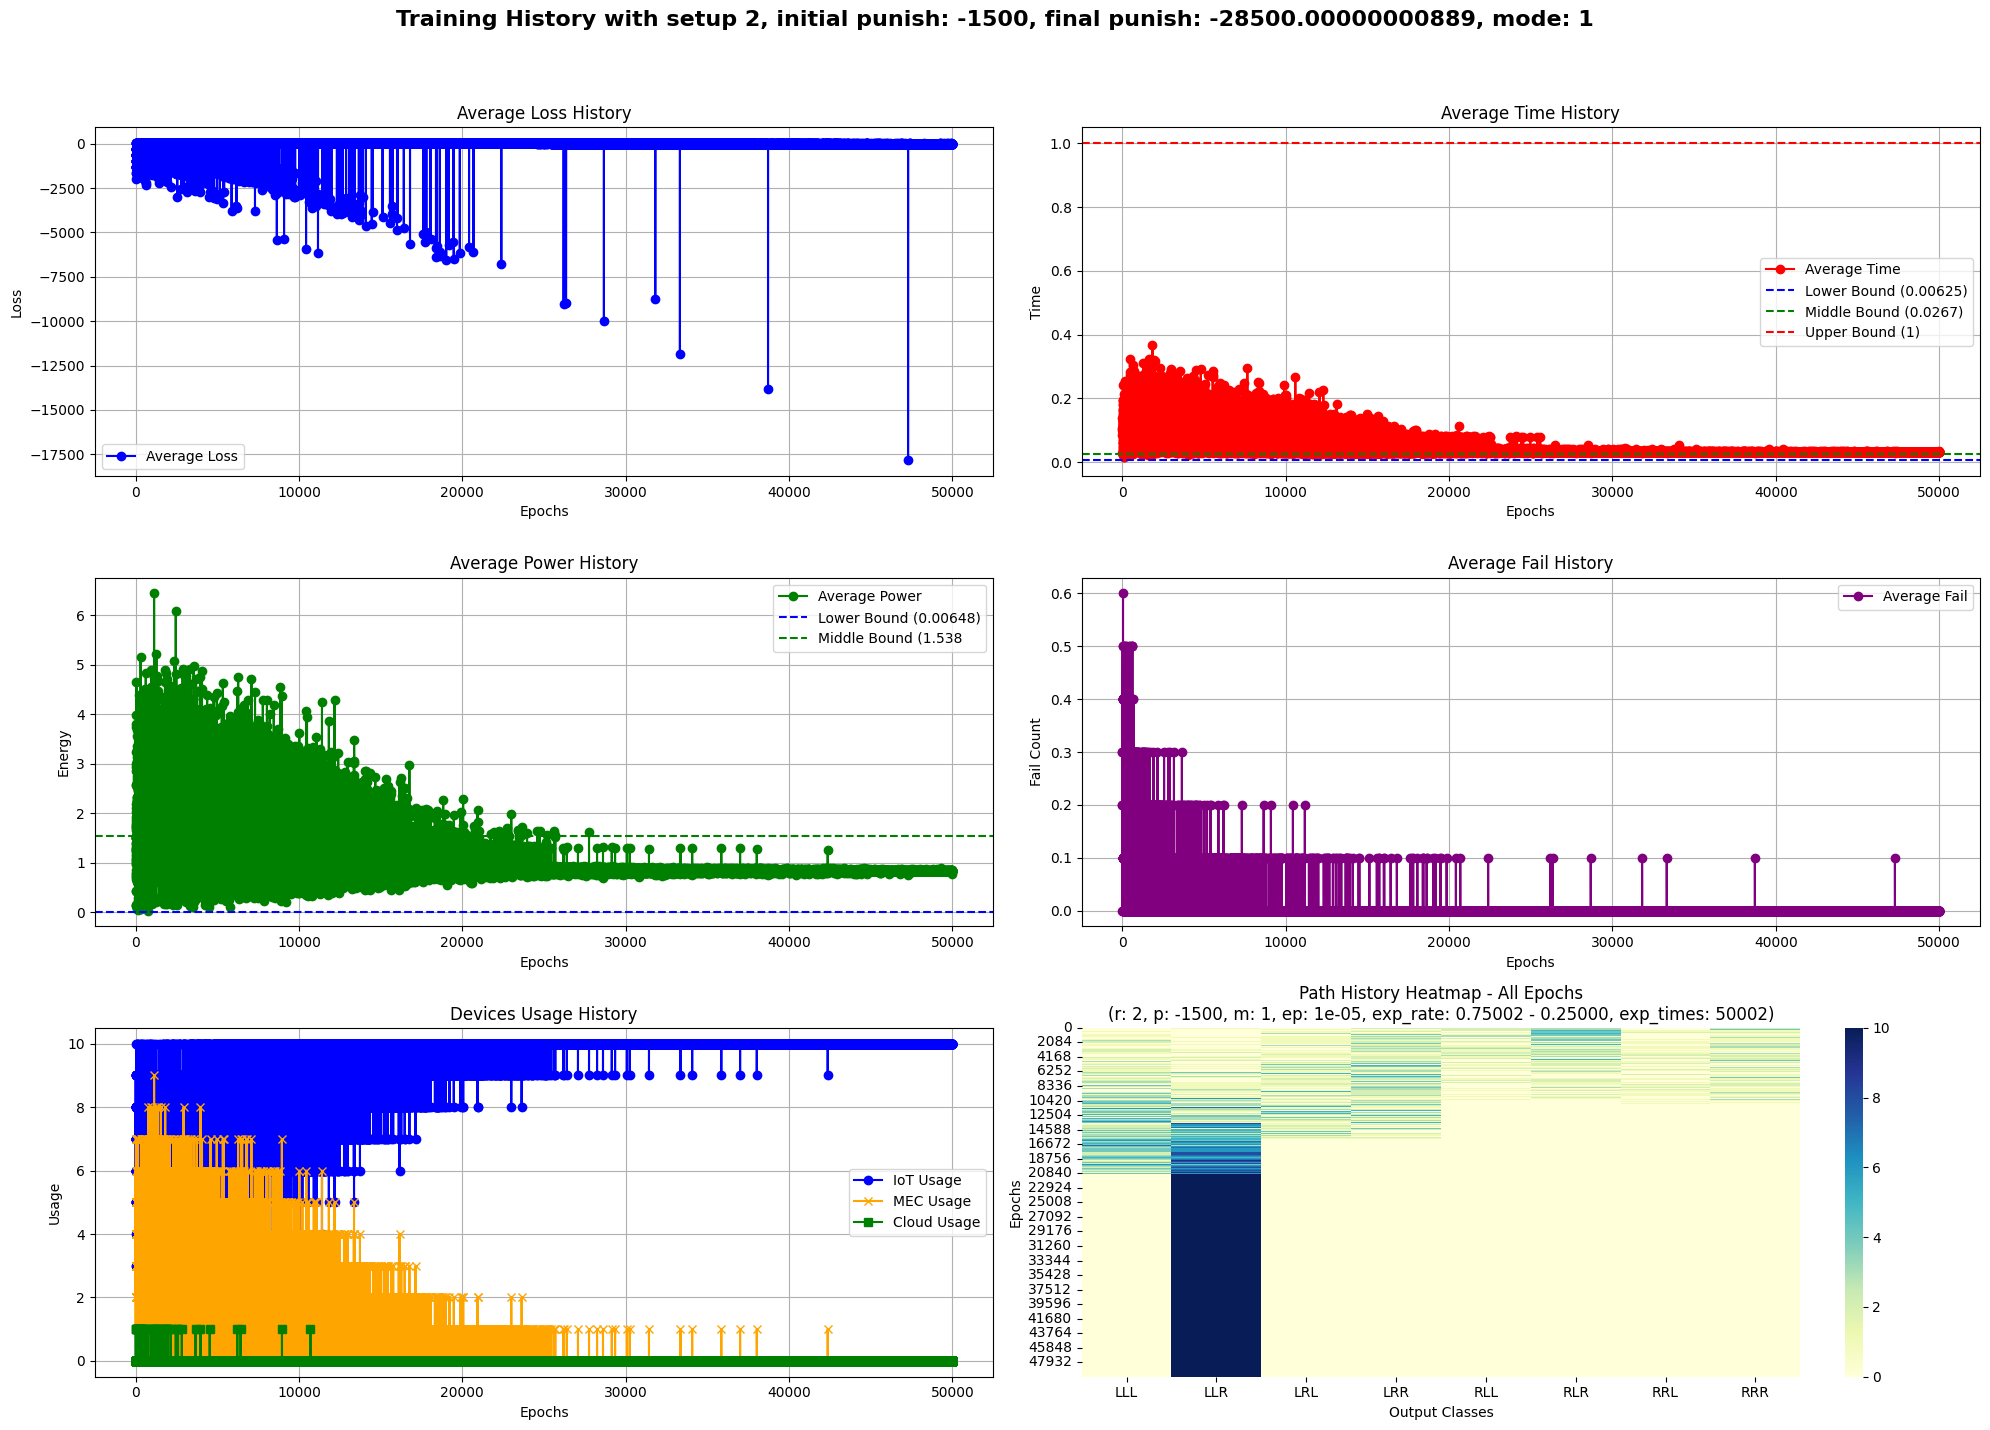

punish epsilon:  -0.03599928001439971
half epochs punish:  -1000.017999639627


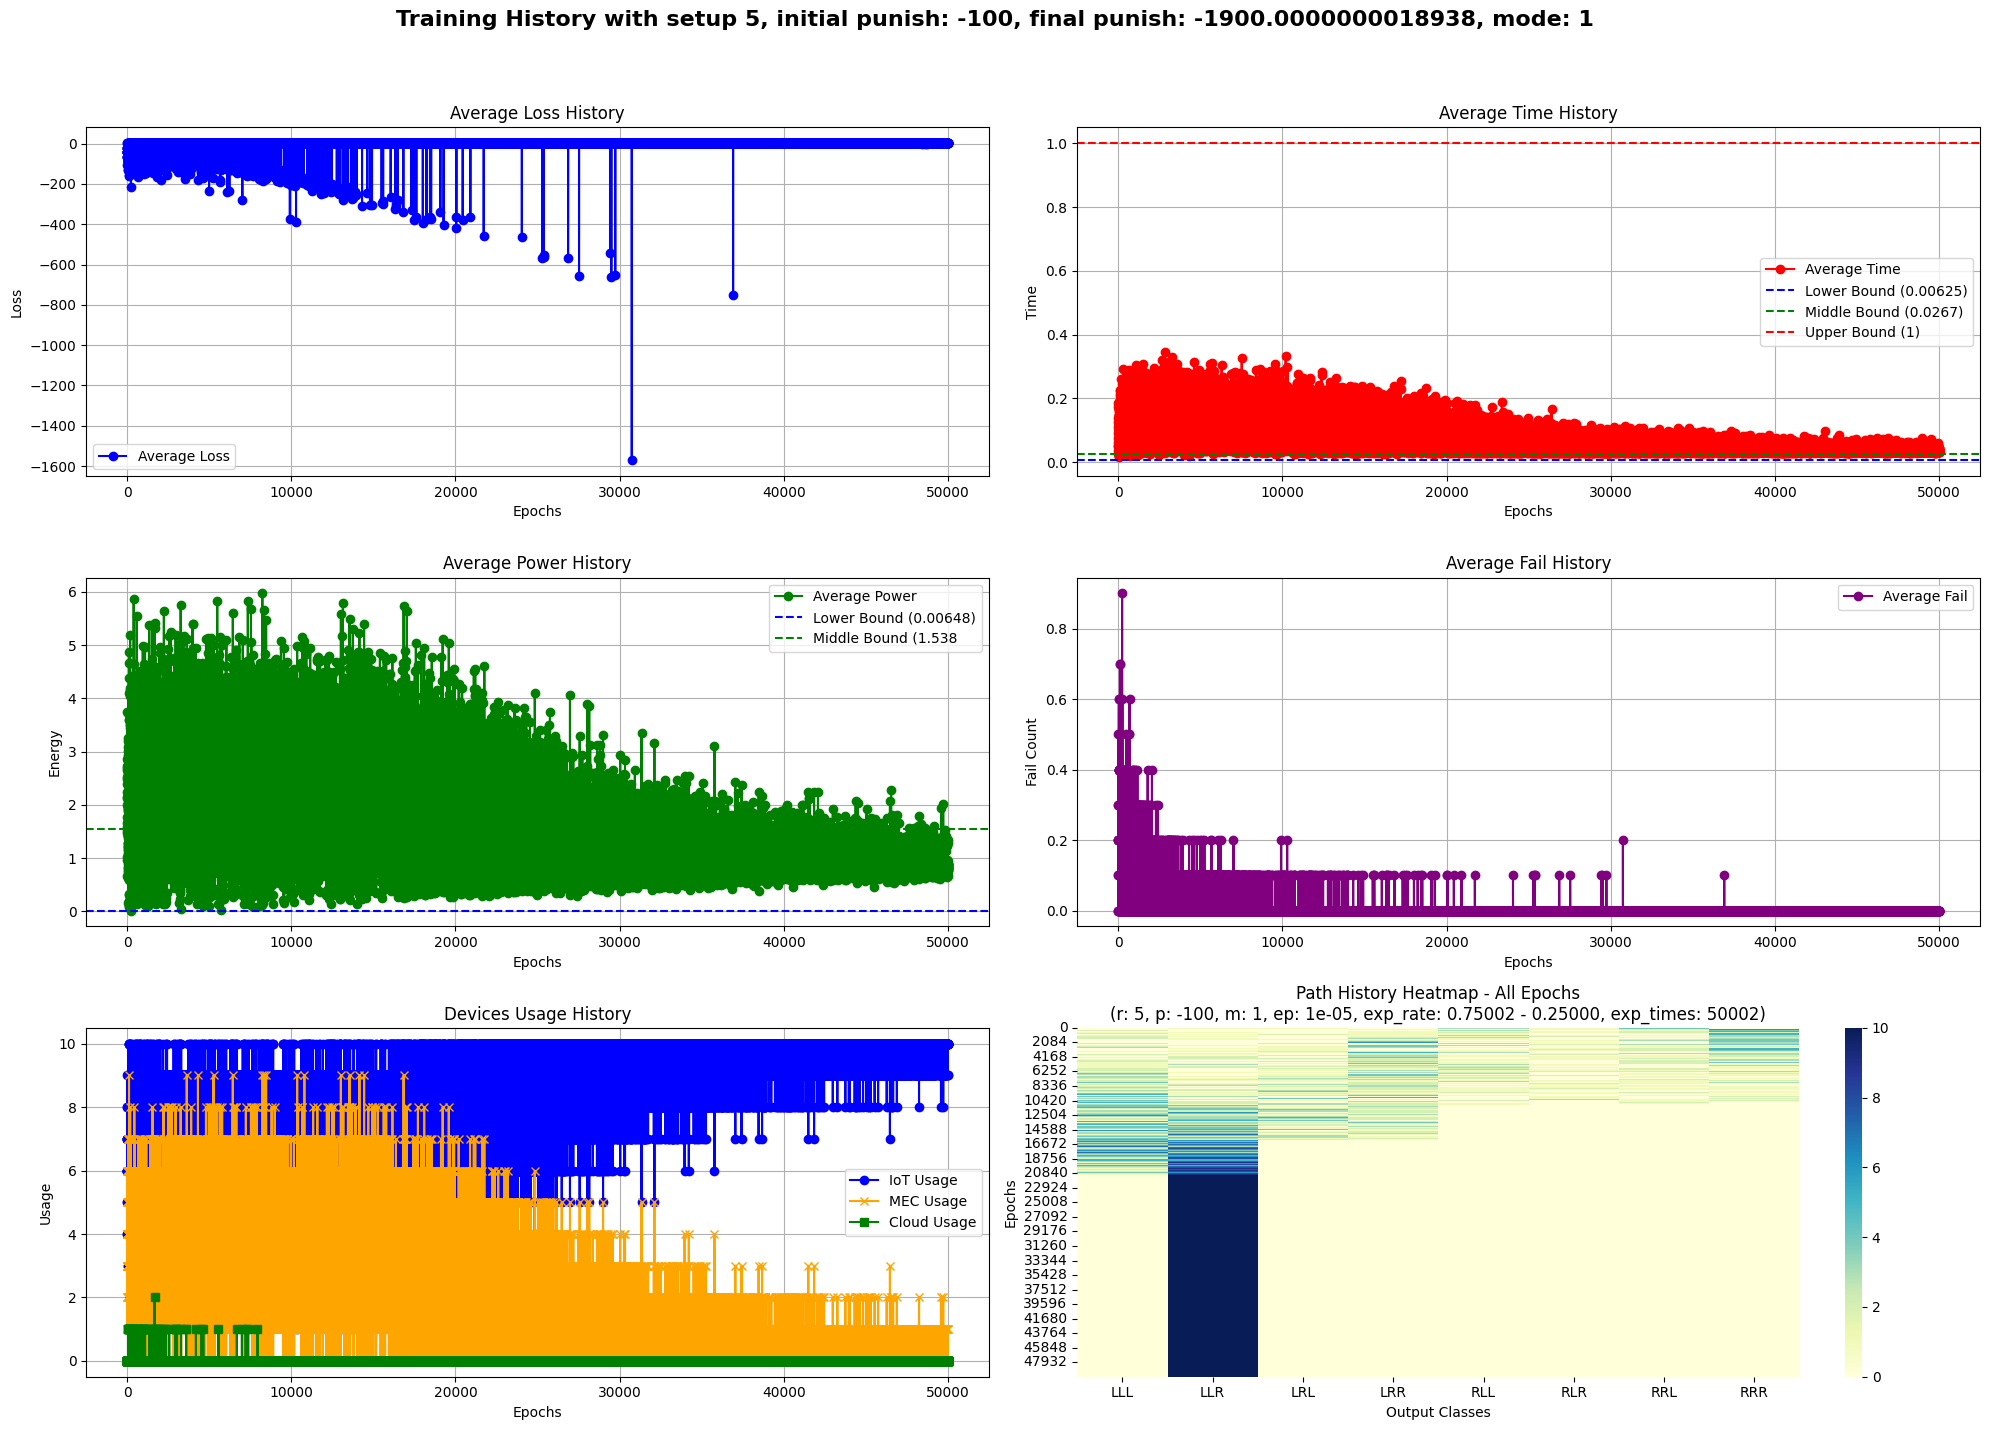

punish epsilon:  -0.08999820003599927
half epochs punish:  -2500.0449991002083


In [30]:

def train_test(n):
    #without regularization
    # rpSetup_list = {1: [-25], 2: [-500], 3: [-175914900], 4: [-183293000], 5: [-75], 6: [-150], 7: [-100] }

    #with regularization
    # rpSetup_list = {1: [-5], 2: [-1500], 3: [-110], 4: [-60], 5: [-100], 6: [-250], 7: [-1] }
    rpSetup_list = {2: [-1500], 5: [-100], 6: [-250]}

    learning_modes = [1]
    for i in range(n):
        for reward, punishments in rpSetup_list.items():
            for punish, mode in itertools.product(punishments, learning_modes): 
                taskList, tasks_copy = read_tasks()
                num_epochs = 50001
                num_episodes = 10
                env = Environment(num_epochs, num_episodes, punish)
                env.learning_mode = mode
                env.rewardSetup = reward
                env.punish_epsilon = -(punish - (punish * 10)) / (num_epochs / 2)
                print("punish epsilon: ", env.punish_epsilon)
                env.taskList = taskList
                env.tasks_copy = tasks_copy
                
                
                tree = env.agent
                env.train(env.num_epochs, env.num_episodes)

train_test(1)   
print("completed")



/var/folders/_r/7fw_p5qd057b2drkmtmpn2l80000gn/T/ipykernel_77987/2640458368.py:8: RuntimeWarning: overflow encountered in exp
  return  -np.exp(alpha * e) - np.exp(beta * t)
/var/folders/_r/7fw_p5qd057b2drkmtmpn2l80000gn/T/ipykernel_77987/2640458368.py:10: RuntimeWarning: overflow encountered in exp
  return  -np.exp(alpha * e + beta * t)


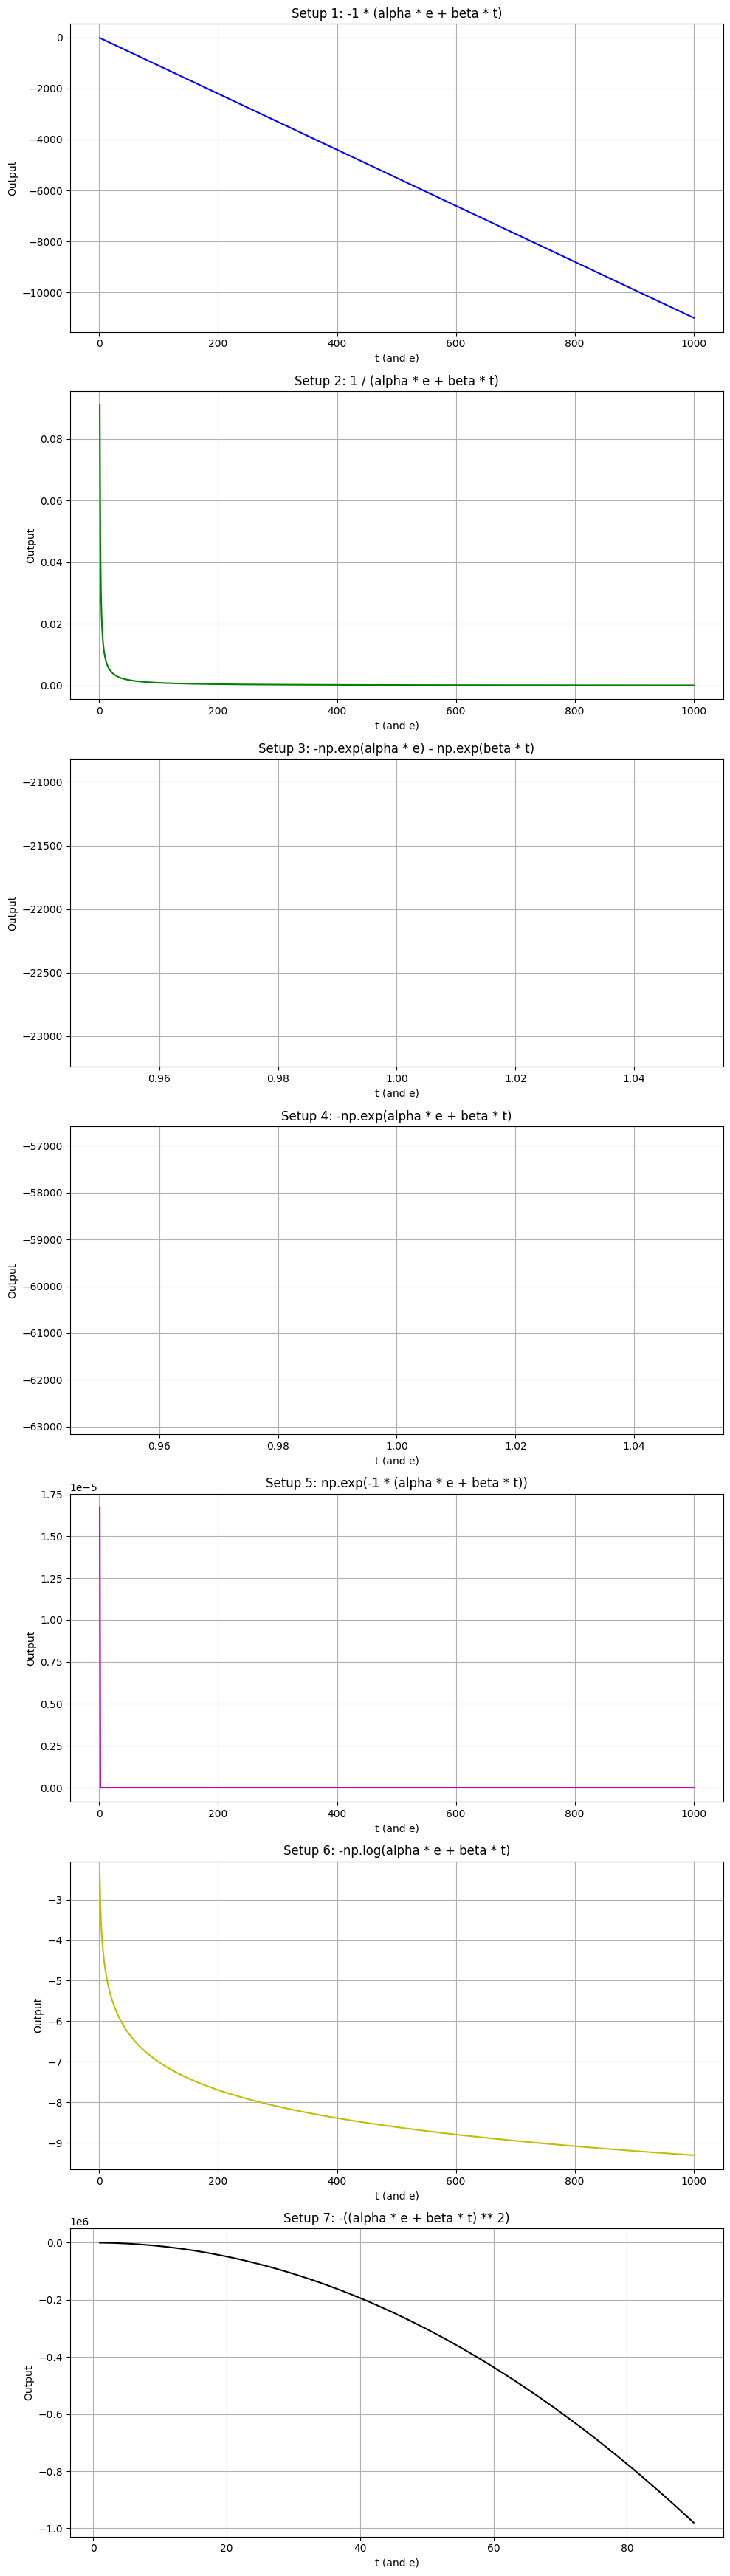

In [ ]:
# Define the range for t and e
t_values = np.arange(1, 1001, 1)  # Start from 1 to avoid divide by zero and log(0)
e_values = np.arange(1, 1001, 1)

# Create subplots for each function
fig, axs = plt.subplots(7, 1, figsize=(10, 35))
setups = range(1, 8)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
titles = [
    "Setup 1: -1 * (alpha * e + beta * t)",
    "Setup 2: 1 / (alpha * e + beta * t)",
    "Setup 3: -np.exp(alpha * e) - np.exp(beta * t)",
    "Setup 4: -np.exp(alpha * e + beta * t)",
    "Setup 5: np.exp(-1 * (alpha * e + beta * t))",
    "Setup 6: -np.log(alpha * e + beta * t)",
    "Setup 7: -((alpha * e + beta * t) ** 2)"
]

for i, setup in enumerate(setups):
    results = []
    for t in t_values:
        e = t  # For simplicity, use e = t
        try:
            result = getSetup(e, t, setup)
            if not np.isfinite(result) or abs(result) > 1e6:  # filter large values to avoid overflow
                result = np.nan
            results.append(result)
        except Exception as ex:
            results.append(np.nan)
    
    axs[i].plot(t_values, results, color=colors[i])
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('t (and e)')
    axs[i].set_ylabel('Output')
    axs[i].grid(True)

plt.tight_layout()
plt.show()